# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import matplotlib
from scipy.interpolate import griddata
# Disable scientific notation
np.set_printoptions(suppress=True)

# Read Image

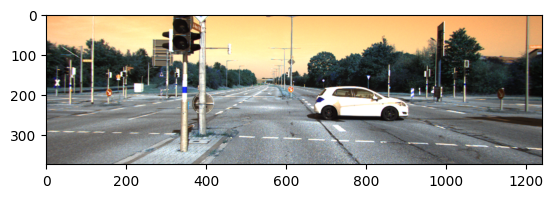

In [3]:
image = cv2.imread('L.png')
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
width, height = image.shape[1], image.shape[0]

# Load Matrices

In [7]:
def load_matrices(intrinsic_matrix_path, extrinsic_matrix_path):
    '''
    Input - velo_2_cam, cam_2_cam
    Output - rotation_matrix, translation_matrix, intrinsic_matrix, extrinsic_matrix, rectification_matrix, projection_matrix
    
    '''
    velo_2_cam = open(extrinsic_matrix_path, "r")
    cam_2_cam = open(intrinsic_matrix_path,'r')

    lines = velo_2_cam.readlines()
    lines2 = cam_2_cam.readlines()

    rotation_matrix = np.array(lines[1][3:-1].split(),dtype=np.float32).reshape(3,3)
    translation_matrix = np.array(lines[2][3:-1].split(),dtype=np.float32).reshape(3,1)

    intrinsic_matrix = np.array(lines2[19][5:-1].split(),dtype = np.float32).reshape(3,3)
    extrinsic_matrix = np.hstack((rotation_matrix, translation_matrix))
    rectification_matrix = np.array(lines2[24][11:-1].split(),dtype = np.float32).reshape(3,3)
    projection_matrix = np.array(lines2[25][11:-1].split(),dtype = np.float32).reshape(-1,4)

    return rotation_matrix, translation_matrix, intrinsic_matrix, extrinsic_matrix, rectification_matrix, projection_matrix


In [8]:
rotation_matrix, translation_matrix, intrinsic_matrix, extrinsic_matrix, rectification_matrix, projection_matrix = load_matrices( 'calib_cam_to_cam.txt', "calib_velo_to_cam.txt")

In [4]:
velo_2_cam = open("calib_velo_to_cam.txt", "r")
cam_2_cam = open('calib_cam_to_cam.txt','r')

lines = velo_2_cam.readlines()
lines2 = cam_2_cam.readlines()

data_r = np.array(lines[1][3:-1].split(),dtype=np.float32).reshape(3,3)
data_t = np.array(lines[2][3:-1].split(),dtype=np.float32).reshape(3,1)

intrinsic_matrix = np.array(lines2[19][5:-1].split(),dtype = np.float32).reshape(3,3)
extrinsic_matrix = np.hstack((data_r, data_t))
rectification_matrix = np.array(lines2[24][11:-1].split(),dtype = np.float32).reshape(3,3)
projection_matrix = np.array(lines2[25][11:-1].split(),dtype = np.float32).reshape(-1,4)

# Create dataframe of lidar points 

In [9]:
def create_points_data(lidar_points_file) :

    '''
    Input -  Path to velodyne points as .bin file extension
    Output - Pandas DataFrame of the points with columns - X, Y, Z and I

    '''
    
    raw_pts = np.fromfile(lidar_points_file, dtype=np.float32).reshape(-1,4)
    points = pd.DataFrame(raw_pts,columns=['X','Y','Z','I'])
    points = points[points['X'] > 0]

    return points


In [11]:
points = create_points_data('V.bin')
points

,X,Y,Z,I
0,32.835999,0.056000,1.319,0.29
1,32.591999,0.107000,1.311,0.29
2,32.404999,0.208000,1.305,0.00
3,60.087002,1.163000,2.241,0.00
4,76.805000,20.544001,2.898,0.00
...,...,...,...,...
116679,3.713000,-1.438000,-1.741,0.00
116680,3.709000,-1.423000,-1.737,0.00
116681,3.707000,-1.409000,-1.733,0.00
116682,3.725000,-1.402000,-1.740,0.00


In [5]:
raw_pts = np.fromfile('V.bin', dtype=np.float32).reshape(-1,4)
points = pd.DataFrame(raw_pts,columns=['X','Y','Z','I'])
points = points[points['X'] > 0]

# Apply fusion algorithm

In [6]:
def fuse_lidar_camera_data(image, lidar_points, R, T, rect_matrix, projection_matrix ):
    
    '''
    Input - Image, Velodyne Points, Rotation Matrix, Translation Vectors, Rectification Matrix and Projection Matrix

    Output - Image with Lidar points fused on the pixels.
    '''
    
    image = cv2.imread('L.png')
    
    pixel_points = []
    lidar_points = []
    
    for i in range(len(points)):
        x, y, z = points.iloc[i,:3]
        depth = math.sqrt(x**2 + y**2 + z**2)

        if 0 < depth < 25 :
            color = (255,0,0)
        elif 25 <= depth <= 50 :
            color = (0,255,0) 
        else :
            color = (0,0,255)

        world_pt = np.array([x,y,z]).T 
        pt_cam_coordinate = np.dot(rotation_matrix, world_pt) + translation_matrix.T.flatten()
        rectified_pt = np.dot(rectification_matrix,pt_cam_coordinate)
        rectified_pt = np.hstack((rectified_pt, [1]))
        projected_pt = np.dot(projection_matrix, rectified_pt)
        u , v  = int(projected_pt[0] / projected_pt[2]), int(projected_pt[1] / projected_pt[2])
        depth = float(projected_pt[2])
        if 0 < u < 1226 :
            if 0 < v < 370 :
                pixel_points.append((u,v))
                lidar_points.append((u,v,int(depth)))
                cv2.circle(image,(u,v),1,color)
    return image
    

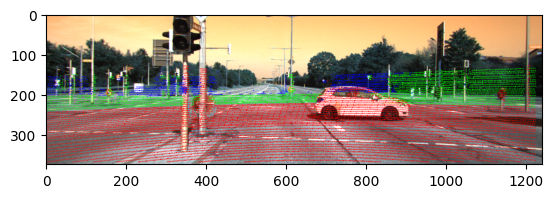

In [17]:
fused_image = fuse_lidar_camera_data(image, points, rotation_matrix, translation_matrix, rectification_matrix, projection_matrix)
plt.imshow(fused_image)

In [38]:
image = cv2.imread('L.png')
pixel_points = []
lidar_points = []

for i in range(len(points)):
    x, y, z = points.iloc[i,:3]
    depth = math.sqrt(x**2 + y**2 + z**2)
    if 0 < depth < 25 :
        color = (255,0,0)
    elif 25 <= depth <= 50 :
        color = (0,255,0) 
    else :
        color = (0,0,255)
    
    world_pt = np.array([x,y,z]).T 
    pt_cam_coordinate = np.dot(data_r, world_pt) + data_t.T.flatten()
    rectified_pt = np.dot(rectification_matrix,pt_cam_coordinate)
    depth = round(float(rectified_pt[2]),2)
    rectified_pt = np.hstack((rectified_pt, [1]))
    projected_pt = np.dot(projection_matrix, rectified_pt)

    u , v  = int(projected_pt[0] / projected_pt[2]), int(projected_pt[1] / projected_pt[2])
    if 0 < u < 1226 :
        if 0 < v < 370 :

            lidar_points.append((u,v,depth))
            cv2.circle(image,(u,v),1,color)
    
lidar_points

[(612, 151, 32.58),
 (611, 151, 32.34),
 (609, 151, 32.15),
 (599, 155, 59.85),
 (419, 157, 76.66),
 (418, 157, 76.28),
 (416, 157, 76.27),
 (413, 157, 76.21),
 (411, 157, 76.01),
 (408, 157, 76.16),
 (402, 137, 8.88),
 (400, 137, 8.86),
 (397, 137, 8.83),
 (395, 137, 8.83),
 (392, 137, 8.81),
 (390, 137, 8.81),
 (389, 137, 8.83),
 (386, 136, 8.69),
 (384, 157, 68.24),
 (381, 157, 68.6),
 (379, 157, 67.67),
 (376, 157, 66.6),
 (374, 157, 66.45),
 (372, 157, 66.71),
 (370, 157, 65.22),
 (367, 157, 65.16),
 (365, 157, 64.93),
 (362, 157, 64.61),
 (360, 157, 64.59),
 (356, 130, 6.92),
 (355, 130, 6.87),
 (352, 130, 6.87),
 (349, 130, 6.86),
 (347, 129, 6.69),
 (344, 130, 6.85),
 (343, 157, 63.63),
 (342, 157, 63.72),
 (334, 155, 35.03),
 (331, 155, 34.85),
 (329, 155, 34.75),
 (326, 155, 34.52),
 (325, 157, 63.41),
 (322, 157, 63.04),
 (319, 155, 35.19),
 (317, 155, 35.23),
 (314, 155, 35.29),
 (312, 157, 61.97),
 (307, 154, 32.58),
 (305, 154, 32.55),
 (296, 154, 31.96),
 (294, 154, 31.8

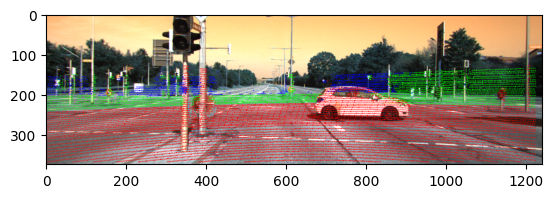

In [39]:
plt.imshow(image)
#cv2.imwrite('Fused.png',image)

In [25]:
lidar_points_np = [(v,u,depth) for (u,v,depth) in lidar_points ]
sparse_depth_map = np.zeros(shape = (height,width))
for i,u,depth in lidar_points_np:
    sparse_depth_map[i,u] = depth

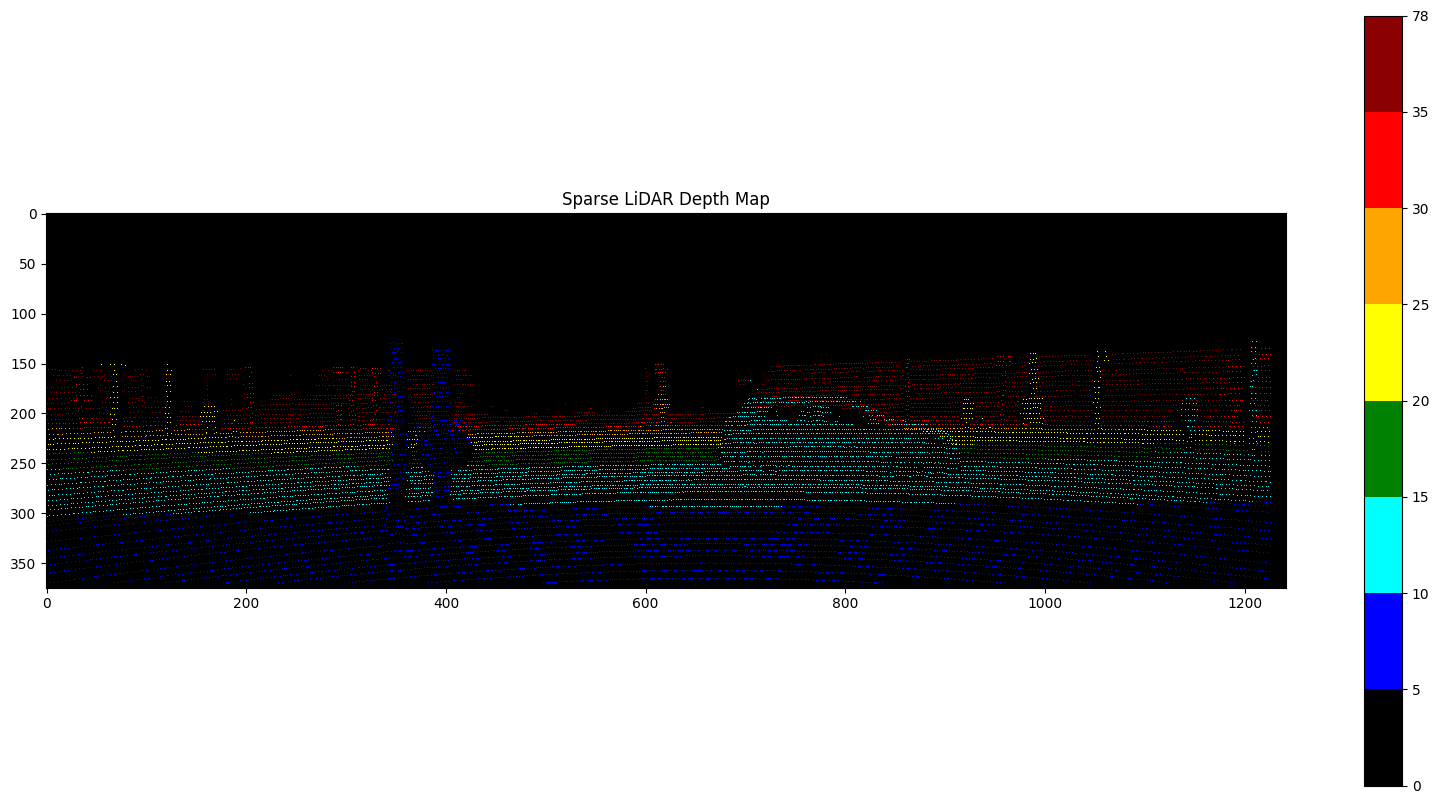

In [26]:
valid_depths = sparse_depth_map[sparse_depth_map > 0]
min_depth , max_depth = valid_depths.min(), valid_depths.max()
bins = [0, 5, 10, 15, 20, 25, 30, 35, np.max(sparse_depth_map)]  # Adjust as needed
colors = ["black", "blue", 'cyan', "green", "yellow", "orange", "red", "darkred"]  # Custom colors

# Create a colormap from the defined colors
cmap = matplotlib.colors.ListedColormap(colors)

# Use BoundaryNorm to ensure bins match colors, but no normalization is applied
norm = matplotlib.colors.BoundaryNorm(bins, cmap.N)
plt.figure(figsize=(20,10))
plt.imshow(sparse_depth_map, cmap=cmap, norm=norm, interpolation='nearest')
plt.title("Sparse LiDAR Depth Map")
plt.colorbar()
plt.savefig('Sparse Point Clouds.png')
plt.show()

#

In [25]:
def view_lidar_points(lidar_file) :

    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)  # (x,y,z,intensity)
    points = points[:, :3]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Optionally colorize points based on height (Z-axis)
    colors = np.zeros_like(points)
    colors[:, 2] = (points[:, 2] - points[:, 2].min()) / np.ptp(points[:, 2])

    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Visualize in 3D viewer
    o3d.visualization.draw_geometries([pcd])

In [27]:
view_lidar_points('V.bin')

# Create dense map

In [95]:
def normalize(list1, min_bound, max_bound):
    '''Normalizes an input lists and returns  list with normalized values'''

    normalized_list = []
    min_value = min(list1)
    difference = max(list1) - min(list1)
    
    for x in list1:
        normalized_value = min_bound +  ((x - min_value) / difference) * (max_bound - min_bound)
        normalized_list.append(int(normalized_value))

    return normalized_list
    

In [123]:
depths = [c for (a,b,c) in filtered_lidar_points]
depths_normalized = normalize(depths,0,255)
filtered_lidar_points_np[i][0:2]

(146, 604)

In [125]:
depths_np = []
for i in range(len(filtered_lidar_points_np)):
    a , b = filtered_lidar_points_np[i][0:2]
    c = depths_normalized[i]
    depths_np.append((a,b,c))

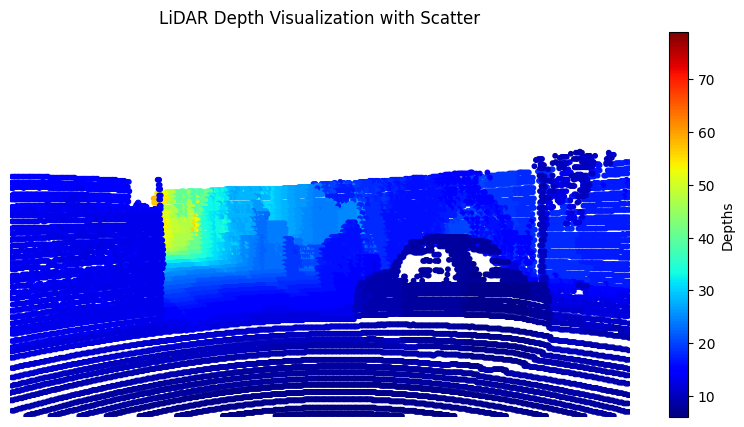

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Define image size (replace with actual image dimensions)

# Convert list to NumPy array
filtered_lidar_points_np = np.array(depths_np)

# Extract pixel coordinates (x, y) and depth values
x_coords = filtered_lidar_points_np[:, 0]
y_coords = filtered_lidar_points_np[:, 1]
depth_values = filtered_lidar_points_np[:, 2]

# Normalize depth values to range [0, 1] for colormap
min_depth, max_depth = np.min(depth_values), np.max(depth_values)
if max_depth > min_depth:
    normalized_depths =(0 + ((depth_values - min_depth) / (max_depth - min_depth)) * (255))
else:
    normalized_depths = np.zeros_like(depth_values)  # Avoid division by zero

# Create scatter plot on a black background
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('black')  # Set black background

# Plot LiDAR points using scatter (color-coded by depth)
plt.scatter(y_coords, x_coords, c=depths, cmap='jet', s=10, alpha=1.0)

# Adjust plot settings
plt.colorbar(label="Depths")
plt.title("LiDAR Depth Visualization with Scatter")
plt.xlim(0, width)   # Set x-axis limits
plt.ylim(height, 0)  # Flip y-axis to match image coordinates
plt.axis('off')      # Hide axes for a clean image
plt.savefig('Lidar.png')
plt.show()


# FoundationStereo

In [4]:
fs_depths = np.load('test_outputs/depth_meter.npy')
fs_depths.shape, image.shape

((375, 1242), (375, 1242, 3))

In [44]:
lidar_points_np = [(v,u,z) for (u,v,z) in lidar_points]

In [19]:
fs_depths_meters = []
fs_depths_disparities = []
diff = []
for i in range(375):
    for j in range(1242):
        disparity = fs_depths[i,j]
        fs_depths_disparities.append(disparity)
        if disparity > 0 :
            fs_depth_meter = float(( 959.7910 * 0.5327 ) / disparity)
            fs_depths_meters.append(fs_depth_meter)

for (u,v,w) in lidar_points_np :
    disparity = fs_depths[u,v]
    lidar_depth = w
    if disparity > 0 :
            fs_depth_meter = float(( 959.7910 * 0.5327 ) / disparity)
            diff.append(abs(lidar_depth-fs_depth_meter))
np.mean(diff)

NameError: name 'lidar_points_np' is not defined

In [20]:
fs_depths = np.load('test_outputs/depth_meter.npy')  # disparity map
lidar_points_np = [(v, u, z) for (u, v, z) in lidar_points]  # convert to (v, u, z)

f = 959.7910  # focal length from K_02
B = 0.5327    # baseline in meters

diffs = []

for (v, u, lidar_depth) in lidar_points_np:
    if 0 <= v < fs_depths.shape[0] and 0 <= u < fs_depths.shape[1]:
        disparity = fs_depths[v, u]  # ✅ correct indexing
        if disparity > 0:
            fs_depth = (f * B) / disparity
            diff = abs(lidar_depth - fs_depth)
            diffs.append(diff)

print("Max error:", np.max(diffs))
print("Mean error:", np.mean(diffs))
print("RMSE:", np.sqrt(np.mean(np.square(diffs))))

NameError: name 'lidar_points' is not defined

In [21]:
dense_depth_map_fs = np.zeros(shape=(375,1242),dtype=np.float32)
for i in range(375):
    for j in range(1242):
        #dense_depth_map_fs[i,j] = fs_depths[i,j] #np.zeros(shape=(375,1242),dtype=np.float32)
        disparity = fs_depths[i,j]
        if disparity > 0 :
            fs_depth_meter = float(( 959.7910 * 0.5327 ) / disparity)
            dense_depth_map_fs[i,j] = fs_depth_meter

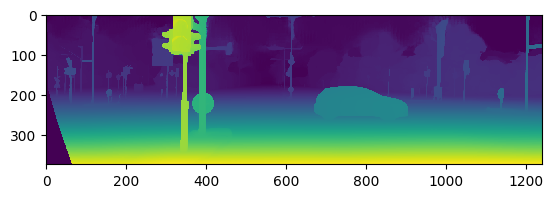

In [22]:
plt.imshow(dense_depth_map_fs, interpolation='nearest')

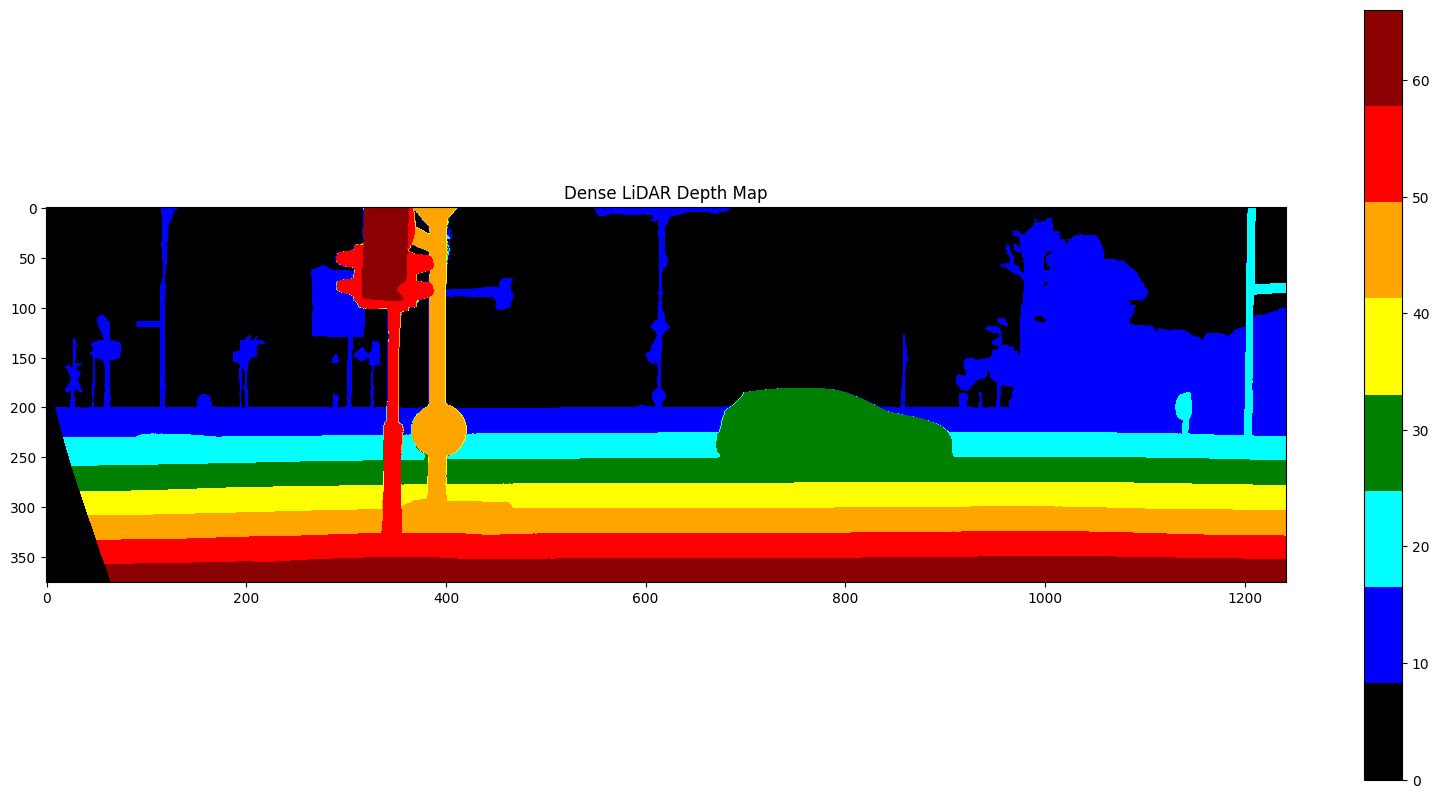

In [25]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, np.max(dense_depth_map_fs)]  # Adjust as needed
colors = ["black", "blue", 'cyan', "green", "yellow", "orange", "red", "darkred"]  # Custom colors

# Create a colormap from the defined colors
cmap = matplotlib.colors.ListedColormap(colors)

# Use BoundaryNorm to ensure bins match colors, but no normalization is applied
norm = matplotlib.colors.BoundaryNorm(bins, cmap.N)
plt.figure(figsize=(20,10))
plt.imshow(dense_depth_map_fs, cmap=cmap)
plt.title("Dense LiDAR Depth Map")
plt.colorbar()
plt.savefig('FS Depth Map.png')
plt.show()

In [18]:
dense_depth_map_fs[250,400]

np.float32(42.954163)